In [33]:
import networkx as nx
import glob
import os
import matplotlib.pyplot as mpl
import seaborn as sns
import pandas as pd
import copy

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

In [34]:
# %matplotlib inline

In [35]:
G = nx.read_gpickle("newdata/20171201/ds-80_reaction_compound_graph_with_attributes.pkl")

#### Add `bipartite` attribute to the nodes (for compounds `bipartite = 0`, for reactions `bipartite = 1`)

In [36]:
len(list(G.nodes()))

1589

In [37]:
r_nodes = [n for n in list(G.nodes()) if n.startswith("R")]

In [38]:
c_nodes = [n for n in list(G.nodes()) if n.startswith("C")]

In [39]:
len(r_nodes)

703

In [40]:
len(c_nodes)

886

In [41]:
bipartite_label = dict()
for c in c_nodes:
    bipartite_label[c] = {"bipartite":0}
    
for r in r_nodes:
    bipartite_label[r] = {"bipartite":1}

    # bipartite_0_nodes = {0: {'attr1': 20, 'attr2': 'nothing'}, 1: {'attr2': 3}}

In [42]:
## Sets the bipartite attribute
nx.set_node_attributes(G, bipartite_label)

In [43]:
# nx.get_node_attributes(G,"bipartite")

In [44]:
compound_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
reaction_nodes = set(G) - compound_nodes

In [45]:
len(compound_nodes)

886

In [46]:
len(reaction_nodes)

703

In [47]:
nx.bipartite.is_bipartite_node_set(G,compound_nodes)

True

#### Find compounds ids which are not in the compound database (and thus have no compound json)

In [48]:
def identify_compounds_which_are_not_in_compound_database(G):
    substrates = nx.get_node_attributes(G,"substrates")
    products = nx.get_node_attributes(G,"products")
    reactions = nx.get_node_attributes(G,"reactions")
    
    c_ids_in_substrates_or_products = set()
    for s in substrates:
        c_ids_in_substrates_or_products.update(set(substrates[s]))
    for p in products:
        c_ids_in_substrates_or_products.update(set(products[p]))
        
    return c_ids_in_substrates_or_products - set(reactions)

In [49]:
compounds_not_in_database = identify_compounds_which_are_not_in_compound_database(G)

In [50]:
def identify_reactions_which_have_compounds_not_in_database(G,compounds_not_in_database):
    # find all reactions which list a compound which is not present in the compound database
    substrates = nx.get_node_attributes(G,"substrates")
    products = nx.get_node_attributes(G,"products")
    reactions = nx.get_node_attributes(G,"reactions")
    
    faulty_reactions = []
    
    for r in substrates:
        if bool(compounds_not_in_database & set(substrates[r])):
            faulty_reactions.append(r)
    for r in products:
        if bool(compounds_not_in_database & set(products[r])):
            faulty_reactions.append(r)
            
    return faulty_reactions

In [51]:
reactions_to_remove = identify_reactions_which_have_compounds_not_in_database(G,compounds_not_in_database)

#### Find reaction ids which are not in the reaction database (and thus have no reaction json)
#### This section doesn't do anything, but it's good to know

In [52]:
substrates = nx.get_node_attributes(G,"substrates")
products = nx.get_node_attributes(G,"products")
reactions = nx.get_node_attributes(G,"reactions")

r_ids_in_reactions = set()
for c in reactions:
    r_ids_in_reactions.update(set(reactions[c]))

In [53]:
len(r_ids_in_reactions)

9141

In [54]:
r_in_sub_prod_dicts = set(substrates) & set(products)

In [55]:
len(r_in_sub_prod_dicts)

703

In [56]:
len(r_ids_in_reactions - r_in_sub_prod_dicts) 

##This list appears to be full of reactions which have glycans. Did I get rid of them here?
## No, they are removed in the "advance_expansion_1_generation" function

8438

In [57]:
# r_ids_in_reactions - r_in_sub_prod_dicts

In [58]:
len(r_in_sub_prod_dicts - r_ids_in_reactions)

0

In [59]:
len(reactions)

886

In [60]:
icount = 0
for i in reactions:
    print i
    icount+=1
    if icount ==5: break

C16471
C05528
C06508
C05527
C19858


In [73]:
'C14819' in list(reactions)

False

In [74]:
'C16471' in list(reactions)

True

In [75]:
ds80_seeds = ['C00011',
'C20298',
'C14819',
'C00087',
'C00237',
'C00058',
'C00033',
'C00031',
'C00095',
'C00124',
'C00159',
'C00243',
'C00208',
'C00282',
'C00007',
'C00001']


In [76]:
for c in ds80_seeds:
    if c not in list(reactions):
        print c

C20298
C14819
C00159


Arsenic,
Iron,
Manose,
are not in DS-80's reactions. 

#### Remove reactions which contain compounds that don't exist

In [62]:
# G['R11803']

In [63]:
G.remove_nodes_from(reactions_to_remove)

### These reactions are now removed

In [64]:
# G['R11803']

### Create generations of networks starting from glucose

In [65]:
def advance_expansion_1_generation(G,current_compounds,current_reactions):

    reactions = nx.get_node_attributes(G,"reactions") # this dict has compounds only
    substrates = nx.get_node_attributes(G,"substrates") # this dict has reactions only
    products = nx.get_node_attributes(G,"products") # this dict has reactions only

    verified_compounds = set()
    verified_reactions = set()
    
    all_potential_reactions = set([r for c in current_compounds for r in reactions[c] if r in substrates]) #this gets rid of glycans
    unverified_reactions = all_potential_reactions - current_reactions

    for r in unverified_reactions:
        if set(products[r]+substrates[r]).issubset(current_compounds):
            verified_reactions.add(r)
            # already have all compounds
        elif set(substrates[r]).issubset(current_compounds):
            verified_compounds.update(set(products[r]))
            verified_reactions.add(r)
        elif set(products[r]).issubset(current_compounds):
            verified_compounds.update(set(substrates[r]))
            verified_reactions.add(r)
            
    verified_new_compounds = verified_compounds - current_compounds
    verified_new_reactions = verified_reactions - current_reactions
                
    return verified_new_compounds,verified_new_reactions

In [84]:
def advance_expansion_to_complete_scope(G,seed_compounds,compounds_to_tag):
    all_compounds = copy.copy(seed_compounds)
    all_reactions = set()
    
    verified_new_compounds = copy.copy(seed_compounds) # anything not length 0
    
#     gen_by_gen = dict()
#     added_per_gen = dict()
    
    list_of_dicts = list()
    
    generation = 0
    while len(verified_new_compounds) != 0:
        ## verified new reactions are @ t-1, verified new compounds are @ t
        verified_old_compounds = copy.copy(verified_new_compounds)
        verified_new_compounds,verified_new_reactions = advance_expansion_1_generation(G,all_compounds,all_reactions)
        
        all_reactions.update(verified_new_reactions)
        
#         gen_by_gen[generation] = {"n_reactions":len(all_reactions),"n_compounds":len(all_compounds)}
#         added_per_gen[generation] = {"n_reactions":len(verified_new_reactions),"n_compounds":len(verified_old_compounds)}
        
        big_dict = dict()
        ## Non network properites
        big_dict['generation'] = generation
        big_dict['n_compounds_new'] = len(verified_old_compounds)
        big_dict['n_reactions_new'] = len(verified_new_reactions)
        big_dict['n_compounds_cumulative'] = len(all_compounds)
        big_dict['n_reactions_cumulative'] = len(all_reactions)
        big_dict['compounds_new'] = list(verified_old_compounds)
        big_dict['reactions_new'] = list(verified_new_reactions)
        big_dict['seed'] = list(seed_compounds)
        
        ## Network properties
        subgraph_nodes = all_compounds | all_reactions ## union of sets
        subG = G.subgraph(subgraph_nodes)
        
#         big_dict['bipartite_avg_clustering'] = nx.bipartite.average_clustering(subG)
#         big_dict['bipartite_avg_clustering_compounds'] = nx.bipartite.average_clustering(subG,all_compounds)
#         big_dict['bipartite_avg_clustering_reactions'] = nx.bipartite.average_clustering(subG,all_reactions)
        
        ## Betweeness centrality        
#         betweenness_dict = nx.bipartite.betweenness_centrality(subG, all_compounds)
        
#         c_betweenness_dict = dict((k, betweenness_dict[k]) for k in all_compounds if k in betweenness_dict)
#         r_betweenness_dict = dict((k, betweenness_dict[k]) for k in all_reactions if k in betweenness_dict)
        
#         big_dict['bipartite_avg_betweenness_compounds'] = sum(c_betweenness_dict.values())/float(len(c_betweenness_dict))
#         big_dict['bipartite_avg_betweenness_reactions'] = sum(r_betweenness_dict.values())/float(len(r_betweenness_dict))
        
        ## Degree
        r_degs,c_degs = nx.bipartite.degrees(subG,all_compounds)
        
#         big_dict['bipartite_avg_deg_compounds'] = sum([i[1] for i in c_degs])/float(len(c_degs))
#         big_dict['bipartite_avg_deg_reactions'] = sum([i[1] for i in r_degs])/float(len(r_degs))
        
        ## Tagged compounds
        current_tags = list()
        for k in compounds_to_tag:
            if k in verified_old_compounds:
                current_tags.append(compounds_to_tag[k])
        if len(current_tags)==0:
            big_dict['tags'] = None
        else:
            big_dict['tags'] = str(current_tags)
        
        print generation
        
        list_of_dicts.append(big_dict)
        
        generation+=1
        
        all_compounds.update(verified_new_compounds)
        
    return list_of_dicts
        

### Run through multiple seed sets

In [67]:
# seed_compounds = set(["C00001","C00031"]) # water and glucose (water is always a seed compound)
# big_dict = advance_expansion_to_complete_scope(G,seed_compounds,compounds_to_tag)

In [96]:
# all_seeds = {'Glucose':set(["C00001","C00031"]),
#              'ATP':set(["C00001","C00002"]),
#              'CoA':set(["C00001","C00010"]),
#              'CO2,NH3,H3PO4,H2SO4':set(["C00001","C00011","C00014","C00009","C00059"])}

# all_seeds = {'CO2_H2_S':set(["C00001","C00011","C00282","C00087"]),
#              'Maltose_O2':set(["C00001","C00208","C00007"])}
# #             'Formate_Fe3':set(["C00001","C00058","C14819"]),

all_seeds = {"CO2 H2  S":set(["C00011","C00282","C00087"]),
"CO  H2  S":set(["C00237","C00282","C00087"]),
"CO  H2  S":set(["C00237","C00282","C00087"]),
"Formate H2  S":set(["C00058","C00282","C00087"]),
"Acetate H2  S":set(["C00033","C00282","C00087"]),
"Glucose H2  S":set(["C00031","C00282","C00087"]),
"Fructose    H2  S":set(["C00095","C00282","C00087"]),
"Galactose   H2  S":set(["C00124","C00282","C00087"]),
"Mannose H2  S":set(["C00159","C00282","C00087"]),
"Lactose H2  S":set(["C00243","C00282","C00087"]),
"Maltose H2  S":set(["C00208","C00282","C00087"]),
"CO2 H2  Fe3+":set(["C00011","C00282","C14819"]),
"CO  H2  Fe3+":set(["C00237","C00282","C14819"]),
"Formate H2  Fe3+":set(["C00058","C00282","C14819"]),
"Acetate H2  Fe3+":set(["C00033","C00282","C14819"]),
"Glucose H2  Fe3+":set(["C00031","C00282","C14819"]),
"Fructose    H2  Fe3+":set(["C00095","C00282","C14819"]),
"Galactose   H2  Fe3+":set(["C00124","C00282","C14819"]),
"Mannose H2  Fe3+":set(["C00159","C00282","C14819"]),
"Lactose H2  Fe3+":set(["C00243","C00282","C14819"]),
"Maltose H2  Fe3+":set(["C00208","C00282","C14819"]),
"CO  CO  Fe3+":set(["C00237","C00237","C14819"]),
"Formate Formate Fe3+":set(["C00058","C00058","C14819"]),
"Acetate Acetate Fe3+":set(["C00033","C00033","C14819"]),
"Glucose Glucose Fe3+":set(["C00031","C00031","C14819"]),
"Fructose    Fructose    Fe3+":set(["C00095","C00095","C14819"]),
"Galactose   Galactose   Fe3+":set(["C00124","C00124","C14819"]),
"Mannose Mannose Fe3+":set(["C00159","C00159","C14819"]),
"Lactose Lactose Fe3+":set(["C00243","C00243","C14819"]),
"Maltose Maltose Fe3+":set(["C00208","C00208","C14819"]),
"Formate Formate O2":set(["C00058","C00058","C00007"]),
"Acetate Acetate O2":set(["C00033","C00033","C00007"]),
"Glucose Glucose O2":set(["C00031","C00031","C00007"]),
"Fructose    Fructose    O2":set(["C00095","C00095","C00007"]),
"Galactose   Galactose   O2":set(["C00124","C00124","C00007"]),
"Mannose Mannose O2":set(["C00159","C00159","C00007"]),
"Lactose Lactose O2":set(["C00243","C00243","C00007"]),
"Maltose Maltose O2":set(["C00208","C00208","C00007"]),
"CO2 S  S":set(["C00011","C00087","C00087"]),
"CO2 S  Fe3+":set(["C00011","C00087","C14819"]),
"CO2 As3+    O2":set(["C00011","C20298","C00007"]),
"CO2 As3+    Fe3+":set(["C00011","C20298","C14819"])}

In [97]:
compounds_to_tag = {"C00003":'NAD',
                   "C00006":'NADP',
                   "C00002":'ATP',
                   "C00031":'Glucose',
                   "C00010":'CoA'}

In [100]:
all_seed_dicts = dict()
for k in all_seeds:
    try:
        result_list_of_dicts = advance_expansion_to_complete_scope(G,all_seeds[k],compounds_to_tag)
        all_seed_dicts[k] = result_list_of_dicts
    except:
        print "%s failed"%k

Mannose H2  S failed
Fructose    H2  Fe3+ failed
0
Acetate Acetate Fe3+ failed
0
1
0
1
2
3
4
CO  CO  Fe3+ failed
CO2 S  Fe3+ failed
CO2 H2  Fe3+ failed
0
Glucose Glucose Fe3+ failed
Mannose H2  Fe3+ failed
0
Fructose    Fructose    Fe3+ failed
0
1
2
3
0
CO2 As3+    Fe3+ failed
Acetate H2  Fe3+ failed
0
0
Glucose H2  Fe3+ failed
Lactose Lactose Fe3+ failed
0
0
1
2
3
0
Galactose   Galactose   Fe3+ failed
Mannose Mannose O2 failed
CO  H2  Fe3+ failed
0
1
0
Formate Formate Fe3+ failed
Formate H2  Fe3+ failed
0
Galactose   H2  Fe3+ failed
CO2 As3+    O2 failed
Maltose Maltose Fe3+ failed
Maltose H2  Fe3+ failed
0
0
1
2
3
4
Lactose H2  Fe3+ failed
Mannose Mannose Fe3+ failed


### Write dfs to file if you just ran the analysis

In [101]:
def write_dfs_to_file(dirname,all_seed_dicts):
    all_seed_dfs = dict()
    
    for seed in all_seed_dicts:
        all_seed_dfs[seed] = pd.DataFrame(all_seed_dicts[seed])
    
    for seed in all_seed_dfs:
        pathname = dirname+seed.replace(',', '_')
        all_seed_dfs[seed].to_json(pathname)

In [102]:
dirname = 'network_expansion_result_jsons_ds80/'
write_dfs_to_file(dirname,all_seed_dicts)

### Otherwise read them from file

In [103]:
def read_dfs_from_file(dirname):
    all_seed_dfs = dict()
    for fname in glob.glob(dirname+'*'):
        seed = fname.split('/')[1]
        all_seed_dfs[seed] = pd.read_json(fname)
    
    return all_seed_dfs

In [104]:
dirname = 'network_expansion_result_jsons_ds80/'
all_seed_dfs = read_dfs_from_file(dirname)

In [107]:
for seed_set in all_seed_dfs:
    print seed_set

Galactose   Galactose   O2
Lactose H2  S
Fructose    Fructose    O2
Formate H2  S
Lactose Lactose O2
Glucose H2  S
Galactose   H2  S
Formate Formate O2
Acetate Acetate O2
Glucose Glucose O2
CO2 H2  S
Maltose Maltose O2
CO2 S  S
Fructose    H2  S
Acetate H2  S
CO  H2  S
Maltose H2  S


### Plot all seed sets on same plot (compounds)

In [119]:
def super_plot(all_seed_dfs,y):
    # Create traces
    traces = list()
    for seed_set in all_seed_dfs:
        _df = all_seed_dfs[seed_set].sort_index()
        _trace = go.Scatter(
        x = _df.index,
        y = _df[y],
        mode = 'lines+markers',#lines+markers+text',
        name = seed_set,
#         text=_df['tags'],
        textposition='top'
    #     text= data['state']
        )
        traces.append(_trace)
    
#     trace0 = go.Scatter(
#         x = df.index,
#         y = df[line1],
#         mode = 'lines+markers+text',
#         name = line1,
#         text=df['tags'],
#         textposition='top'
#     #     text= data['state']
#     )
#     trace1 = go.Scatter(
#         x = df.index,
#         y = df[line2],
#         mode = 'lines+markers',
#         name = line2
#     )

#     data = [trace0,trace1]
    plotly.offline.iplot(traces)

In [120]:
super_plot(all_seed_dfs,'n_compounds_new')

In [121]:
super_plot(all_seed_dfs,'n_reactions_new')

In [122]:
print "hello"

hello


In [123]:
super_plot(all_seed_dfs,'n_compounds_cumulative')

In [124]:
super_plot(all_seed_dfs,'n_reactions_cumulative')

### Create plots of the different seed set data

In [93]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        text=df['tags'],
        textposition='top'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

In [95]:
cool_plots(all_seed_dfs['Maltose_O2'],'n_compounds_new','n_reactions_new')

#### Test run

In [46]:
compounds_to_tag = {"C00003":'NAD',
                   "C00006":'NADP',
                   "C00002":'ATP',
                   "C00031":'Glucose',
                   "C00010":'CoA'}

In [48]:
seed_compounds = set(["C00001","C00031"]) # water and glucose (water is always a seed compound)
list_of_dicts = advance_expansion_to_complete_scope(G,seed_compounds,compounds_to_tag)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [51]:
glucose_df = pd.DataFrame(list_of_dicts)

In [52]:
glucose_df.head()

,bipartite_avg_betweenness_compounds,bipartite_avg_betweenness_reactions,bipartite_avg_clustering,bipartite_avg_clustering_compounds,bipartite_avg_clustering_reactions,bipartite_avg_deg_compounds,bipartite_avg_deg_reactions,compounds_new,generation,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,reactions_new,seed,tags
0,0.388889,0.083333,0.750000,0.750000,0.750000,3.500000,1.750000,"[C00001, C00031]",0,2,2,4,4,"[R00307, R00306, R00028, R00010]","[C00001, C00031]",['C00031']
1,0.229167,0.051263,0.405139,0.219766,0.466930,6.000000,2.000000,"[C00185, C01083, C00095, C00208]",1,6,4,18,14,"[R00026, R02887, R09995, R00801, R10817, R0519...","[C00001, C00031]",None
2,0.072944,0.026941,0.241998,0.133498,0.294857,5.210526,2.538462,"[C00159, C06468, C06219, C00221, C00267, C0008...",2,19,13,39,21,"[R10809, R01519, R01332, R01823, R00015, R0210...","[C00001, C00031]",None
3,0.045824,0.025422,0.217042,0.149991,0.260770,4.300000,2.804348,"[C00252, C02336, C00257, C01742, C02492, C0366...",3,30,11,46,7,"[R11788, R01538, R11790, R08612, R03802, R1130...","[C00001, C00031]",None
4,0.038721,0.022192,0.211131,0.148474,0.252902,4.277778,2.851852,"[C06218, C21655, C17207, C00372, C00204, C21659]",4,36,6,54,8,"[R11789, R08614, R08570, R02120, R01540, R0212...","[C00001, C00031]",None


In [68]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        text=df['tags'],
        textposition='top'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

In [69]:
cool_plots(glucose_df,'n_compounds_new','n_reactions_new')

NameError: name 'glucose_df' is not defined

In [70]:
cool_plots(glucose_df,'n_compounds_cumulative','n_reactions_cumulative')

In [71]:
cool_plots(glucose_df,'bipartite_avg_betweenness_compounds','bipartite_avg_betweenness_reactions')

In [72]:
cool_plots(glucose_df,'bipartite_avg_clustering_compounds','bipartite_avg_clustering_reactions')

In [73]:
cool_plots(glucose_df,'bipartite_avg_deg_compounds','bipartite_avg_deg_reactions')

In [110]:
all_seed_dicts = dict()
for k in all_seeds:
    single_dict = advance_expansion_to_complete_scope(G,all_seeds[k],compounds_to_tag)
    all_seed_dicts[k] = single_dict

0
1
2
3
4
5
6
7
8
9


KeyError: u'C21593'

#### Test plotting

In [63]:
df_total = pd.DataFrame(gen_by_gen)
df_pergen = pd.DataFrame(added_per_gen)

NameError: name 'gen_by_gen' is not defined

In [107]:
df_total.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
n_compounds,2,6,19,30,36,41,48,66,86,118,...,240,246,255,264,271,275,281,285,286,288
n_reactions,4,18,39,46,54,60,78,100,138,183,...,297,308,317,326,330,337,342,343,345,345


In [108]:
df_pergen.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
n_compounds,2,4,13,11,6,5,7,18,20,32,...,10,6,9,9,7,4,6,4,1,2
n_reactions,4,14,21,7,8,6,18,22,38,45,...,8,11,9,9,4,7,5,1,2,0


In [109]:
df_pergen = df_pergen.transpose()

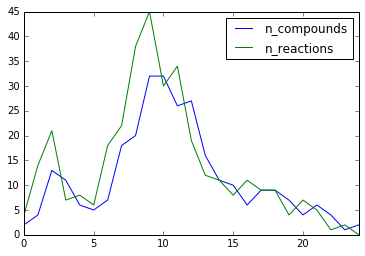

In [110]:
df_pergen.plot()

In [60]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
plotly.offline.init_notebook_mode(connected=True) 

In [61]:
plotly.__version__

'2.1.0'

In [129]:
list(df_pergen['n_compounds'])

[2,
 4,
 13,
 11,
 6,
 5,
 7,
 18,
 20,
 32,
 32,
 26,
 27,
 16,
 11,
 10,
 6,
 9,
 9,
 7,
 4,
 6,
 4,
 1,
 2]

In [62]:
# Create traces
trace0 = go.Scatter(
    x = df_pergen.index,
    y = list(df_pergen['n_compounds']),
    mode = 'lines+markers',
    name = 'compounds',
    text=['Text D', 'Text E', 'Text F']
#     text= data['state']
)
trace1 = go.Scatter(
    x = list(df_pergen.index),
    y = list(df_pergen['n_reactions']),
    mode = 'lines+markers',
    name = 'reactions'
)

data = [trace0,trace1]
plotly.offline.iplot(data)

NameError: name 'df_pergen' is not defined

In [64]:
N = 100
random_x = np.linspace(0, 1, N)
random_y0 = np.random.randn(N)+5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers+text',
    name = 'markers',
    text=[None,None,None,None,None,None,'Text D', 'Text E', 'Text F'],
    textposition='top'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'lines',
    name = 'lines'
)

data = [trace0, trace1, trace2]
plotly.offline.iplot(data)

Need columns for:
- generation
- value (either n_compounds or n_reactions)
- seed_compound

In [80]:
df = df.transpose()

In [90]:
df.head()

,n_compounds,n_reactions
0,2,4
1,6,18
2,19,39
3,30,46
4,36,54


In [97]:
df2 = df.reset_index()

In [98]:
df2.head()

,index,n_compounds,n_reactions
0,0,2,4
1,1,6,18
2,2,19,39
3,3,30,46
4,4,36,54


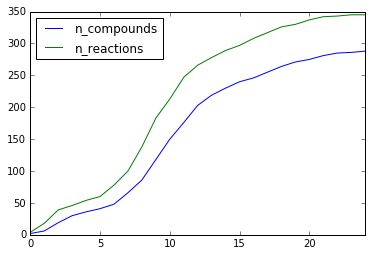

In [103]:
df.plot()

In [102]:
# df.plot()
# df2.plot(kind='scatter',x="index",y='n_compounds')
# df2.plot(kind='scatter',x="index",y='n_reactions',color="green")

# # df.plot(kind='scatter', x='a', y='b',
# #    ....:              color='DarkBlue', label='Group 1');

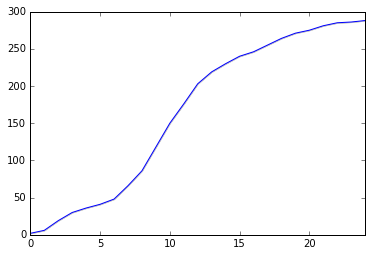

In [85]:
sns.tsplot(df['n_compounds'])

In [62]:
seed_compounds = set(["C00001","C00031"]) # water and glucose (water is always a seed compound)
verified_new_compounds,verified_new_reactions = advance_expansion_1_generation(G,seed_compounds,set())

In [63]:
verified_new_compounds

{u'C00095', u'C00185', u'C00208', u'C01083'}

In [64]:
verified_reactions

{u'R00010', u'R00028', u'R00306', u'R00307'}

In [22]:
s = set(range(3))

In [23]:
bigset = set(range(10))

In [29]:
if s.issubset(bigset):
    print "it's in"

it's in


In [44]:
s

{0, 1, 2}

In [43]:
bigset

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
bigset.difference_update()

In [27]:
s in bigset

False

In [28]:
s <= bigset

True

In [30]:
set(range(3)+range(5))

{0, 1, 2, 3, 4}

In [31]:
range(3)+range(5)

[0, 1, 2, 0, 1, 2, 3, 4]

In [ ]:
seed_compounds = (["C00001","C00031"]) # water and glucose (water is always a seed compound)